# Build an *ARMA* Predictive Time Series Model for Larcenies

import python modules

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import statsmodels.api as sm
from math import sqrt

set figure size

In [5]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

# Load the data and clean

read the raw data set from CSV file

In [6]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [7]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


In [8]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [9]:
df.index = df['incident_dt']

# Extract larceny theft per month over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [10]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [11]:
larceny_incidents['incident_dt'].count()

27657

lets roll up the events up by month and study the pattern over time

In [12]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [13]:
X = larceny_monthly_counts.rename('lar_cnts')

In [14]:
X.describe()

count    161.000000
mean     171.782609
std       41.954394
min       26.000000
25%      149.000000
50%      166.000000
75%      198.000000
max      286.000000
Name: lar_cnts, dtype: float64

In [15]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: lar_cnts, dtype: int64

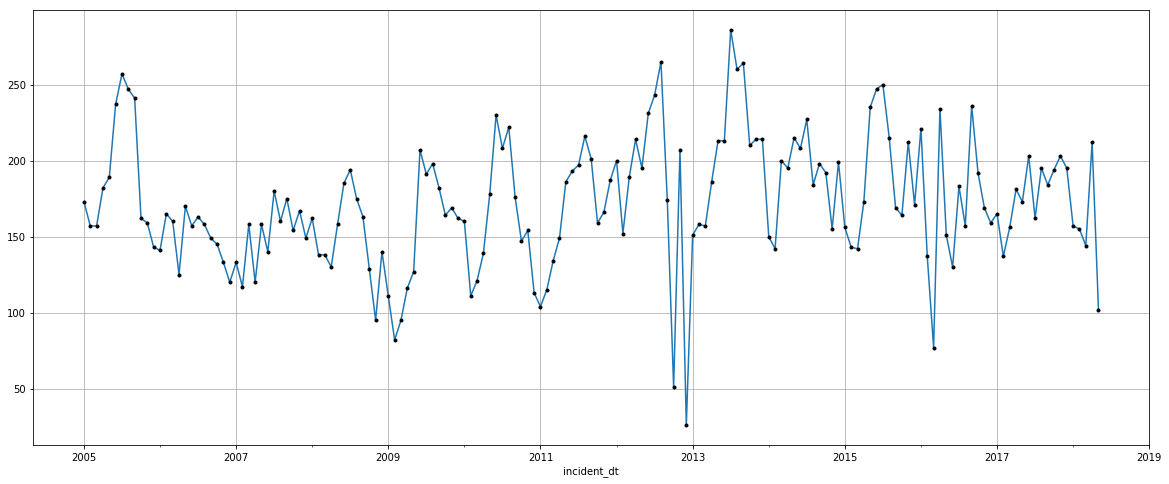

In [16]:
X.plot()
X.plot(style='k.', grid=True)

## Section 1.1 Modeling the data with a time series analysis

lets build an ARMA model

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

lets look at the ACF and PACF for signs of seasonality

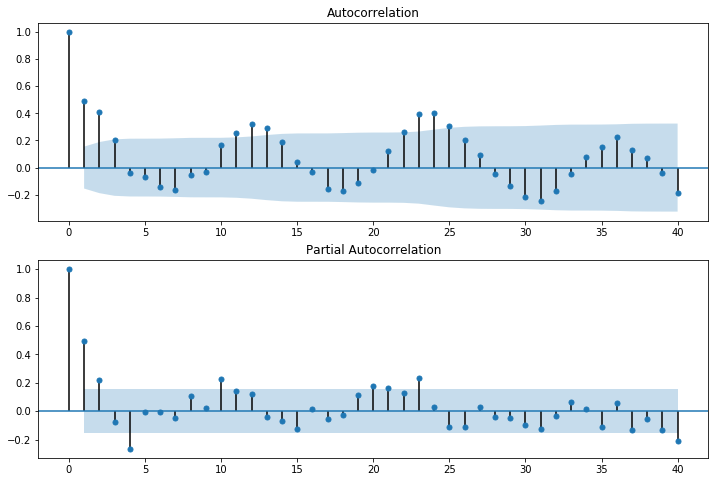

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X, lags=40, ax=ax2)

*Looks like a seasonal effect right around 12 months*

http://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html

statsmodels documentation suggests fitting an AR model to find the right lag 

In [16]:
model = sm.tsa.AR(X)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)

Lag: 14


A lag of 14 months is our "magic" number. But 12 months makes more sense based on the domain

In [18]:
arma_mod1 = sm.tsa.ARMA(X, (14,1)).fit(disp=False)
arma_mod2 = sm.tsa.ARMA(X, (12,0)).fit(disp=False)

In [19]:
print(arma_mod1.aic, arma_mod1.bic, arma_mod1.hqic)
print(arma_mod2.aic, arma_mod2.bic, arma_mod2.hqic)

1611.3347141881493 1663.718588392885 1632.6046950764487
1607.5306332267503 1650.6702943365328 1625.047088075938


In [20]:
predicted = arma_mod2.predict(150, 160, dynamic=True)
actual = X[150:160]
compare = pd.DataFrame(actual)
compare.columns = ['actual']
compare['predicted'] = predicted
compare['difference'] = compare['actual'] - compare['predicted']
compare['percent error'] = (compare['difference']/compare['actual']) * 100.
print(compare)

             actual   predicted  difference  percent error
incident_dt                                               
2017-07-31      162  192.883023  -30.883023     -19.063595
2017-08-31      195  192.065206    2.934794       1.505022
2017-09-30      184  198.495268  -14.495268      -7.877863
2017-10-31      194  181.962543   12.037457       6.204875
2017-11-30      203  179.962210   23.037790      11.348665
2017-12-31      195  170.786254   24.213746      12.417306
2018-01-31      157  160.070912   -3.070912      -1.955995
2018-02-28      155  162.436139   -7.436139      -4.797509
2018-03-31      144  159.966739  -15.966739     -11.088013
2018-04-30      212  167.720804   44.279196      20.886413


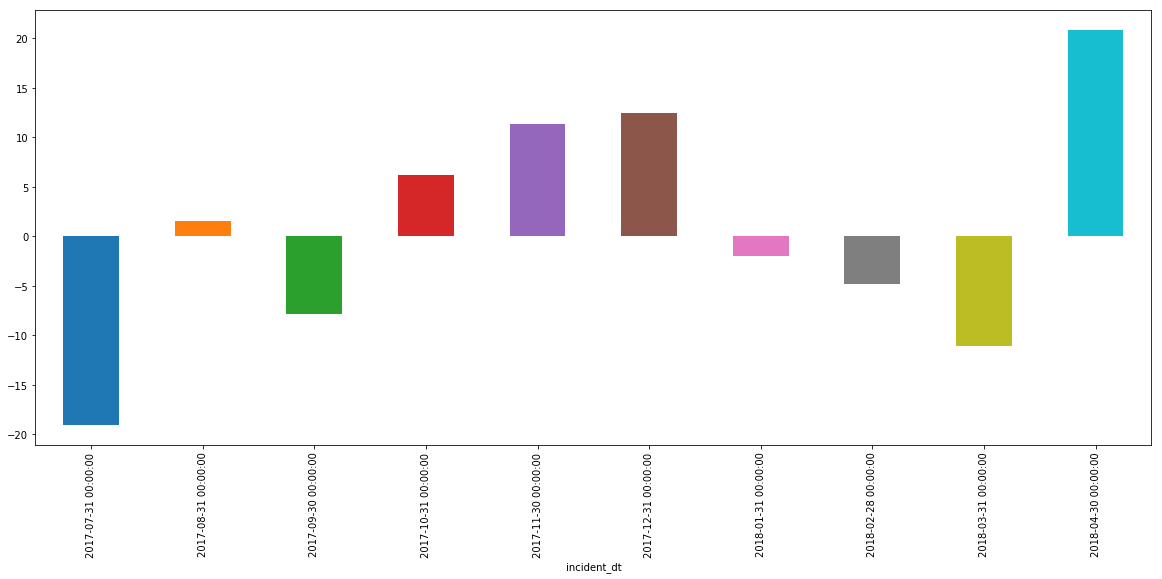

In [25]:
compare['percent error'].plot(kind='bar')

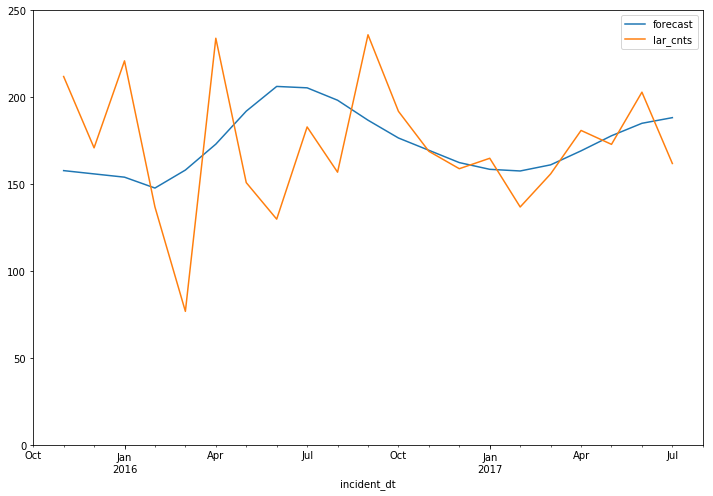

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax = X[150:].plot(ax=ax)
plt.ylim(0, 250)
fig = arma_mod2.plot_predict(130, 150, dynamic=True, ax=ax, plot_insample=True)

Lets do a thought experiment where we train the model on some number of months TM and use it to predict forward for some number of months PM

In [27]:
TM = 100 #train months
PM = 10 #predict months

In [31]:
train_size = TM
predict_size = PM
train, test = X[0:train_size], X[train_size:train_size + predict_size]
# using the 12 month model
predicted = arma_mod2.predict(train_size, train_size + predict_size, dynamic=True)

In [32]:
compare = pd.DataFrame(test)
compare.columns = ['actual']
compare['predicted'] = predicted
print(compare)

             actual   predicted
incident_dt                    
2013-05-31      213  191.463456
2013-06-30      213  199.501488
2013-07-31      286  233.254863
2013-08-31      260  183.408178
2013-09-30      264  199.548442
2013-10-31      210  153.889570
2013-11-30      214  149.438202
2013-12-31      214  140.255209
2014-01-31      150  141.959980
2014-02-28      142  150.412908


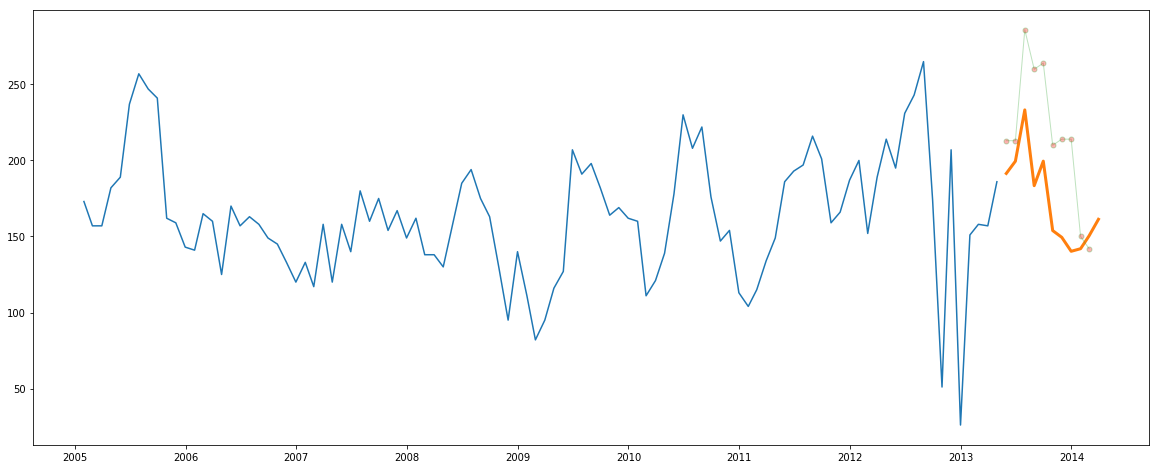

In [30]:
plt.plot(train)
plt.plot(predicted, lw=3.0)
plt.plot(test, '-o', ms=5, lw=1, alpha=0.3, mfc='red')